In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Hackathon/')

In [2]:
import pandas as pd
import numpy as np

In [3]:
#pip install -U huggingface_hub

In [4]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

# Data

In [5]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Hackathon/'
df = pd.read_csv(DATA_PATH + 'data.csv')

In [6]:
df.target = df.target.str.replace('\xad', '')
df.target = df.target.str.replace('\u00ad', '')
df.target = df.target.str.replace('\t', '')
df.target = df.target.str.replace('\N{SOFT HYPHEN}', '')

In [7]:
df.head()

,Unnamed: 0,target,source
0,0,Та пыгрисит маим вармаль э̄рнэ поратэт ат верм...,Те мальчики не выполнят задание в назначенный ...
1,1,"Ха̄йтыматэ тӯр ва̄тан ёхтыс, вит ва̄тан ха̄йтыс.","Бегая к берегу озера пришла, к воде подбежала."
2,2,Вит са̄мыл сунсым о̄нтыс,Вода прибывала на глазах
3,3,"Атаявев, акваг лылынг тагл ворн та тотавев.","Обнюхивает нас, живыми на кладбище уносит."
4,4,"Ман ты пӣлтал, веськат хумиюв нэтхуньт ат ёр...",Мы никогда не забудем этого честного человека.


In [8]:
len(df)

81146

In [9]:
import sentencepiece as spm
from tqdm.auto import tqdm
from transformers import NllbTokenizer
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model


all_texts_file = 'mns_texts_plain.txt'
SPM_PREFIX = 'spm_mansi_16k'
NEW_SPM_NAME = 'spm_nllb_mansi_268k.model'

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_train, df_test_split = train_test_split(df, test_size=0.1, random_state=121)

In [12]:
df_test, df_validation = train_test_split(df_test_split, test_size=0.5, random_state=121)

In [13]:
len(df_train)

73031

# Tokenization

In [14]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [15]:
tokenizer_old = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M', vocab_file=NEW_SPM_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [16]:
n_new_tokens = len(tokenizer) - len(tokenizer_old)
print(n_new_tokens)

14731


In [17]:
def fix_tokenizer(tokenizer, new_lang='mns_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [18]:
fix_tokenizer(tokenizer)

In [19]:
print(tokenizer.convert_ids_to_tokens([270933, 270934, 270935])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'mns_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'mns_Cyrl', '<mask>']
[270933, 270934, 270935]


In [20]:
added_token_id = tokenizer.convert_tokens_to_ids('mns_Cyrl')
similar_lang_old_id = tokenizer_old.convert_tokens_to_ids('hun_Latn')
print(added_token_id, similar_lang_old_id)

270934 256071


In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 270936. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(270936, 1024)

In [22]:
moved_tokens = list(tokenizer_old.lang_code_to_id) + ['<mask>']

In [23]:
model.model.shared.weight.data[tokenizer.convert_tokens_to_ids(moved_tokens)] = model.model.shared.weight.data[tokenizer_old.convert_tokens_to_ids(moved_tokens)]

In [24]:
model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('mns_Cyrl')] = model.model.shared.weight.data[tokenizer_old.convert_tokens_to_ids('hun_Latn')]

In [25]:
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))

14731


In [26]:
for t in tqdm(added_vocab):
    if t == 'mns_Cyrl':
        continue
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        print(f'empty token "{t}"/{tokenizer.convert_tokens_to_ids(t)}')
        tt = [tokenizer_old.unk_token_id]
    model.model.shared.weight.data[tokenizer.convert_tokens_to_ids(t)] = model.model.shared.weight.data[tt].mean(0)

  0%|          | 0/14731 [00:00<?, ?it/s]

In [27]:
#encoded_test = tokenizer.encode('Рӯпитанэ̄тэ сыс, хорамыӈ яныг кол ӯнттувес ос йильпи ищхӣпыӈ утыл ёвтвес.')#, add_special_tokens=False

In [28]:
#tokenizer.decode(encoded_test) #

In [29]:
#tokenizer.save_pretrained("./new_mansi_tokenizer")

In [30]:
#tokenizer.convert_tokens_to_ids('hun_Latn') #[('source', 'rus_Cyrl'), ('target', 'mns_Cyrl')]

In [31]:
#tokenizer.decode([270934])

# Prep Train

In [32]:

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [33]:
import random

LANGS = [('source', 'rus_Cyrl'), ('target', 'mns_Cyrl')]

def get_batch_pairs(batch_size, data=df_train, p_clean=0.5):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]) if random.random() < p_clean else item[l1])
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

#get_batch_pairs(1)

In [34]:
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor, AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup

import gc
import numpy as np

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [35]:
model.cuda();

In [36]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [37]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 60000
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/Hackathon/models_rus_mns'

In [38]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

# Train

In [39]:
x, y, loss = None, None, None
cleanup()

In [ ]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses) + 16000, 200_000)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/184000 [00:00<?, ?it/s]

16000 4.953700065612793


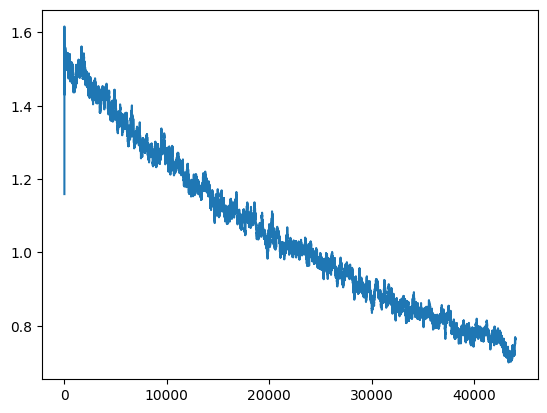

In [ ]:

pd.Series(losses).ewm(100).mean().plot();

In [ ]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_test_split)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['далай']
['море']
['морской']


In [ ]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc/tokenizer_config.json',
 '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc/special_tokens_map.json',
 '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc/sentencepiece.bpe.model',
 '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc/added_tokens.json')

# Evaluation

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
#model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model_load_name = '/content/drive/MyDrive/Colab Notebooks/Hackathon/models_rus_mns'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

In [ ]:
def translate(
    text, src_lang='rus_Cyrl', tgt_lang='eng_Latn',
    a=32, b=3, max_input_length=1024, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

# Example usage:
t = 'Ма̄ но̄х ялты.'
print(translate(t, 'mns_Cyrl', 'rus_Cyrl'))
# ['серебро от времени чернеет']

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

print(bleu_calc.corpus_score(df_test_split['rus_translated'].tolist(), [df_test_split['source'].tolist()]))
print(chrf_calc.corpus_score(df_test_split['rus_translated'].tolist(), [df_test_split['source'].tolist()]))
print(bleu_calc.corpus_score(df_test_split['mns_translated'].tolist(), [df_test_split['target'].tolist()]))
print(chrf_calc.corpus_score(df_test_split['mns_translated'].tolist(), [df_test_split['target'].tolist()]))

# BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
# chrF2++ = 49.49
# BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
# chrF2++ = 50.89

In [ ]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]